In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys

import numpy as np
from tqdm import tqdm

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [2]:
# 21cmFAST
import logging
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

import py21cmfast as p21c
from py21cmfast import plotting, cache_tools

print(f'Using 21cmFAST version {p21c.__version__}')
if os.environ['USER'] == 'yitians' and 'submit' in os.uname().nodename:
    p21c.config['direc'] = '/scratch/submit/ctp/yitians/21cmFAST-cache'

/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  "Your configuration file is out of date. Updating..."
/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


Using 21cmFAST version 0.1.dev1578+g6f96f89.d20230216


In [3]:
# darkhistory and dm21cm
import jax.numpy as jnp

if os.environ['USER'] == 'yitians' and 'submit' in os.uname().nodename:
    os.environ['DM21CM_DATA_DIR'] = '/data/submit/yitians/DM21cm'
    os.environ['DH_DIR'] = '/work/submit/yitians/darkhistory/DarkHistory'

sys.path.append('..')
sys.path.append(os.environ['DH_DIR'])
    
from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.spectools as spectools

import dm21cm.physics as phys
from dm21cm.common import abscs_nBs_test_2 as abscs
from dm21cm.interpolators import BatchInterpolator

## 1. Injection

### 1.1 Evoli Messinger Ferrara

In [4]:
def get_EMF_f_boxs(delta_B_box, x_e_box):
    
    return {
        'heat' : (1 + 2 * x_e_box) / 3,
        'ion'  : (1 - x_e_box) / 3,
        'exc'  : (1 - x_e_box) / 3,
    }

### 1.2 DarkHistory

In [5]:
dep_interp = BatchInterpolator(os.environ['DM21CM_DATA_DIR'] + '/transferfunctions/nBs_test_2/phot_dep_dlnz4.879E-2_renxo_ad.p')

In [6]:
def get_DH_f_boxs(delta_B_box, x_e_box, z=None, **process):
    
    # add check shape
    DIM = delta_B_box.shape[0]
    
    nBs_box = jnp.clip(jnp.array(1 + delta_B_box), 0, 15)
    nBs_in = nBs_box.flatten()
    x_box = jnp.array(x_e_box)
    x_in = x_box.flatten()
    
    spec = spectools.rebin_N_arr(np.array([1]), np.array([process['mDM']]), out_eng=abscs['photE'])
    spec_E = jnp.array(spec.N * spec.eng)
    spec_E /= jnp.sum(spec_E)
    f_boxs = dep_interp(1+z, spec.N, nBs_in, x_in).reshape(DIM, DIM, DIM, 5) / spec.toteng()
    
    out_absc = np.array(dep_interp.abscs['out'])
    
    return {
        'heat' : f_boxs[:,:,:, np.where(out_absc=='heat')[0][0]  ],
        'ion'  : f_boxs[:,:,:, np.where(out_absc=='H ion')[0][0] ] + f_boxs[:,:,:, np.where(out_absc=='He ion')[0][0] ],
        'exc'  : f_boxs[:,:,:, np.where(out_absc=='exc')[0][0]   ],
    }

## 2. Run

In [7]:
def get_z_arr(z_start=p21c.global_params.Z_HEAT_MAX, z_end=20):
    
    z_arr = [z_end]
    while np.max(z_arr) < z_start:
        z_prev = (1 + np.max(z_arr)) * p21c.global_params.ZPRIME_STEP_FACTOR - 1
        z_arr.append(z_prev)
    return np.array(z_arr[::-1][1:])

In [49]:
cache_tools.clear_cache()

2023-02-23 16:27:12,081 | INFO | Removing PerturbedField_dd335247f9fd8328c14920834d2dd4f6_r54321.h5
INFO:21cmFAST:Removing PerturbedField_dd335247f9fd8328c14920834d2dd4f6_r54321.h5
2023-02-23 16:27:12,094 | INFO | Removing TsBox_a511f7e3a4129d80fe5611341e357a60_r54321.h5
INFO:21cmFAST:Removing TsBox_a511f7e3a4129d80fe5611341e357a60_r54321.h5
2023-02-23 16:27:12,106 | INFO | Removing IonizedBox_2d032335980a5265d71d5ebd7f5c8fcd_r54321.h5
INFO:21cmFAST:Removing IonizedBox_2d032335980a5265d71d5ebd7f5c8fcd_r54321.h5
2023-02-23 16:27:12,116 | INFO | Removing IonizedBox_d76bc9d464104bb3531a4bb01c19aaf4_r54321.h5
INFO:21cmFAST:Removing IonizedBox_d76bc9d464104bb3531a4bb01c19aaf4_r54321.h5
2023-02-23 16:27:12,126 | INFO | Removing TsBox_f5f1575814f6de845f1495e10cf8d8ab_r54321.h5
INFO:21cmFAST:Removing TsBox_f5f1575814f6de845f1495e10cf8d8ab_r54321.h5
2023-02-23 16:27:12,135 | INFO | Removing TsBox_9d2ac1bf9da1ba5cc5a7793deee84bce_r54321.h5
INFO:21cmFAST:Removing TsBox_9d2ac1bf9da1ba5cc5a7793deee

In [50]:
# initialize
BOX_CF_LEN = 50 # [Mpc]
LOWRES_DIM = 50 # [1]
VOXEL_SIDE_CF_LENGTH = BOX_CF_LEN / LOWRES_DIM # [Mpc]

initial_conditions = p21c.initial_conditions(
    user_params = {"HII_DIM": LOWRES_DIM, "BOX_LEN": BOX_CF_LEN},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
    random_seed=54321, write=True
)

# redshift
# in DarkHistory: rs = 1 + z
p21c.global_params.ZPRIME_STEP_FACTOR = 1.05
z_arr = get_z_arr(z_end=20)
print('redshift')
print(z_arr)

# dark matter
swave_process = dict(
    mode = 'swave',
    mDM = 2e6, # [eV]
    sigmav = 1e-26, # [cm^-3 s^-1]
)
decay_process = dict(
    mode = 'decay',
    mDM = 1e6, # [eV]
    lifetime = 3e25, # [s]
)
process = swave_process

redshift
[34.91712652 33.20678716 31.57789254 30.02656432 28.54910888 27.14200845
 25.80191281 24.52563125 23.310125   22.1525     21.05       20.        ]


In [51]:
input_mode = 'DH'

records = []
record = {}
i_slice = int(LOWRES_DIM/2)

# first step special case
i_z = 0
z = z_arr[i_z]

print(f'i_z={i_z} 1+z={1+z:.3f}')

# perturbed_field to control redshift
perturbed_field = p21c.perturb_field(redshift=z, init_boxes=initial_conditions)
spin_temp = p21c.spin_temperature(
    perturbed_field=perturbed_field,
    previous_spin_temp=None,
    write=True
)
ionized_box = p21c.ionize_box(spin_temp=spin_temp)

record['delta'] = perturbed_field.density[i_slice]
record['T_s'] = spin_temp.Ts_box[i_slice]
record['x_e'] = 1 - ionized_box.xH_box[i_slice]
record['heat'] = np.zeros_like(record['delta'])
record['ion'] = np.zeros_like(record['delta'])
#record['exc'] = np.zeros_like(record['delta'])
records.append(record.copy())

for i_z, z in enumerate(z_arr[1:], start=1):
    
    print(f'i_z={i_z} 1+z={1+z:.3f}')
    
    # perturbed_field to control redshift
    perturbed_field = p21c.perturb_field(redshift=z, init_boxes=initial_conditions) # [1] | delta_DM
    
    # input boxes
    input_heating = p21c.input_heating(redshift=z, init_boxes=initial_conditions, write=False)
    input_ionization = p21c.input_ionization(redshift=z, init_boxes=initial_conditions, write=False)
    input_jalpha = p21c.input_jalpha(redshift=z, init_boxes=initial_conditions, write=False)

    if input_mode == 'circle':
        input_heating.input_heating += get_circle_seq_at(50, 3, i_z)
        input_ionization.input_ionization += get_circle_seq_at(50, 5, 9-i_z) * 1e-3
        
    elif input_mode == 'DH':
        
        z_prev = z_arr[i_z-1]
        
        # 1. calculate total E_inj
        rho_DM_box = phys.rho_DM * (1+z)**3 * (1 + perturbed_field.density) # [eV cm^-3]
        n_B_box = phys.n_B * (1+z)**3 * (1 + perturbed_field.density) # [cm^-3] | assuming delta_B = delta_DM
        x_e_box = 1 - ionized_box.xH_box # [1]

        dE_inj_dVdt_box = phys.inj_rate_box(rho_DM_box, **process) # [eV cm^-3 s^-1]
        if process['mode'] == 'swave':
            struct_boost_factor = phys.struct_boost_func(model='erfc')(1+z)
            dE_inj_dVdt_box *= struct_boost_factor
            print(f'1+B(z) = {struct_boost_factor}')

        dt = phys.dt_between_z(z_prev, z)
        dE_inj_per_B_box = dE_inj_dVdt_box * dt / n_B_box # [eV per B]
        
        # 2. get f
        f_boxs = get_DH_f_boxs(perturbed_field.density, x_e_box, z=z, **process)
        
        # 3. input
        input_heating.input_heating += np.array(2 / (3*phys.kB*(1+x_e_box)) * dE_inj_per_B_box * f_boxs['heat']) # [K]
        input_ionization.input_ionization += np.array(dE_inj_per_B_box * f_boxs['ion'] / phys.rydberg) # [1 per B]
        #input_jalpha.input_jalpha += dE_inj_per_B_box * f_boxs['exc'] / phys.lya_eng # [???]
        
    else:
        raise NotImplementedError
    
    spin_temp = p21c.spin_temperature(
        perturbed_field=perturbed_field,
        previous_spin_temp=(None if i_z==0 else spin_temp),
        input_heating_box=input_heating,
        input_ionization_box=input_ionization,
        write=True
    )
    
    ionized_box = p21c.ionize_box(spin_temp=spin_temp)
    
    record['delta'] = perturbed_field.density[i_slice]
    record['T_s']   = spin_temp.Ts_box[i_slice]
    record['x_e']   = 1 - ionized_box.xH_box[i_slice]
    record['heat']  = ( dE_inj_per_B_box * f_boxs['heat'] / dt )[i_slice] # [eV s^-1 per B] | dE/dt per B
    record['ion']   = ( dE_inj_per_B_box * f_boxs['ion']  / dt )[i_slice] # [eV s^-1 per B] | dE/dt per B
    #record['exc']   = input_jalpha.input_jalpha[i_slice]
    records.append(record.copy())

i_z=0 1+z=35.917


Just Before Box Evaluation


i_z=1 1+z=34.207


1+B(z) = 13.696625944975237
Just Before Box Evaluation


i_z=2 1+z=32.578


1+B(z) = 19.424143967377404
Just Before Box Evaluation


i_z=3 1+z=31.027


1+B(z) = 27.082851552339303
Just Before Box Evaluation


i_z=4 1+z=29.549


1+B(z) = 37.10395016414378
Just Before Box Evaluation


i_z=5 1+z=28.142


1+B(z) = 49.96204891273188
Just Before Box Evaluation


i_z=6 1+z=26.802


1+B(z) = 66.17208047702836
Just Before Box Evaluation


i_z=7 1+z=25.526


1+B(z) = 86.28623362837827
Just Before Box Evaluation


i_z=8 1+z=24.310


1+B(z) = 110.89124036333195
Just Before Box Evaluation


i_z=9 1+z=23.153


1+B(z) = 140.6062866099209
Just Before Box Evaluation


i_z=10 1+z=22.050


1+B(z) = 176.08173821180512
Just Before Box Evaluation


i_z=11 1+z=21.000


1+B(z) = 217.9987988690349
Just Before Box Evaluation


In [63]:
for i in range(11):
    print(np.mean(records[i]['ion']))

0.0
3.0216457e-18
3.5279133e-18
4.048372e-18
4.564048e-18
5.0564533e-18
5.5080307e-18
5.907674e-18
6.2435365e-18
6.5070213e-18
6.6970366e-18


100%|██████████| 12/12 [00:18<00:00,  1.57s/it]


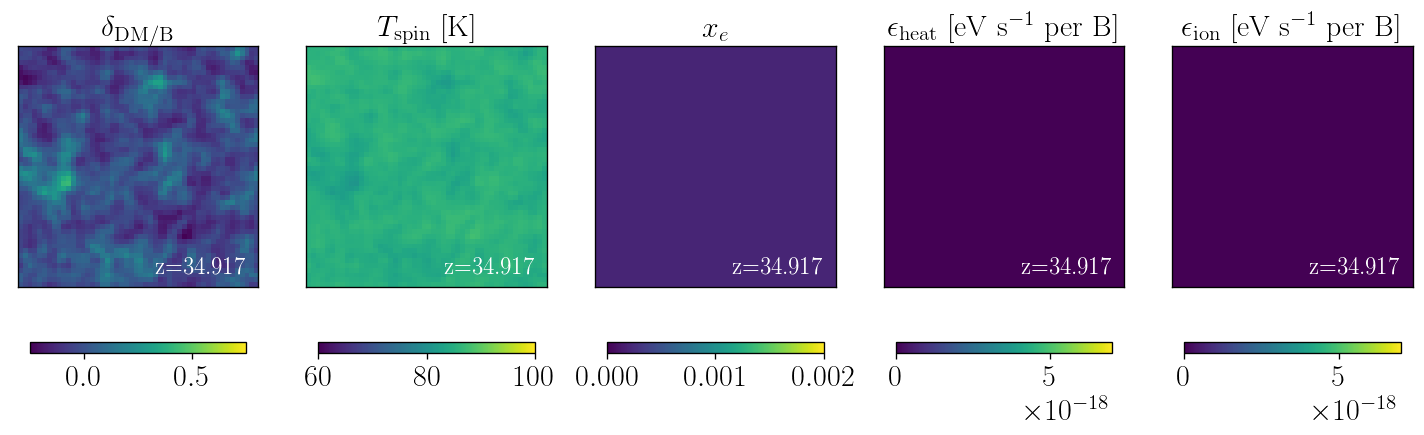

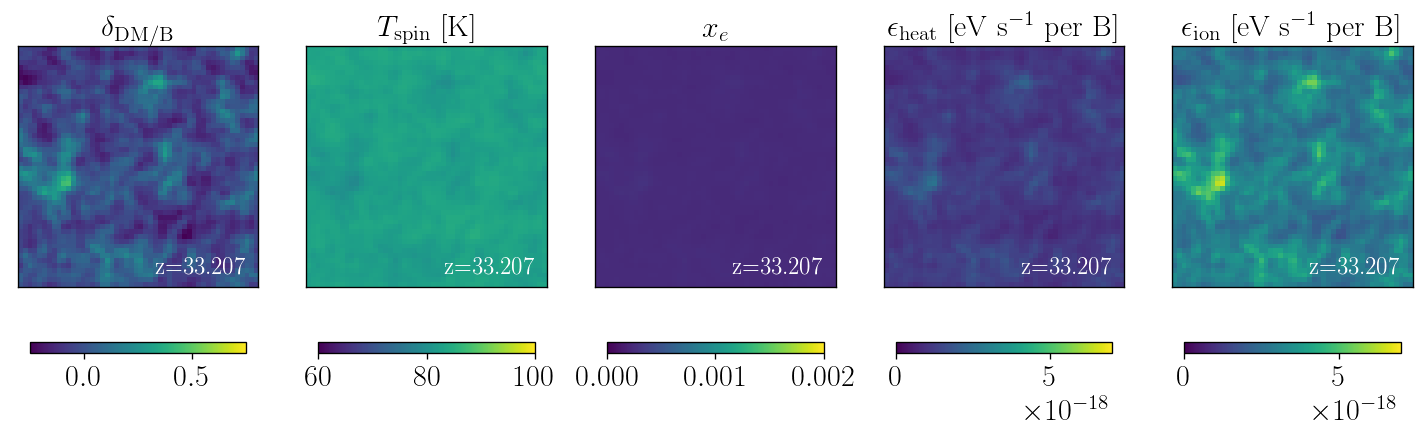

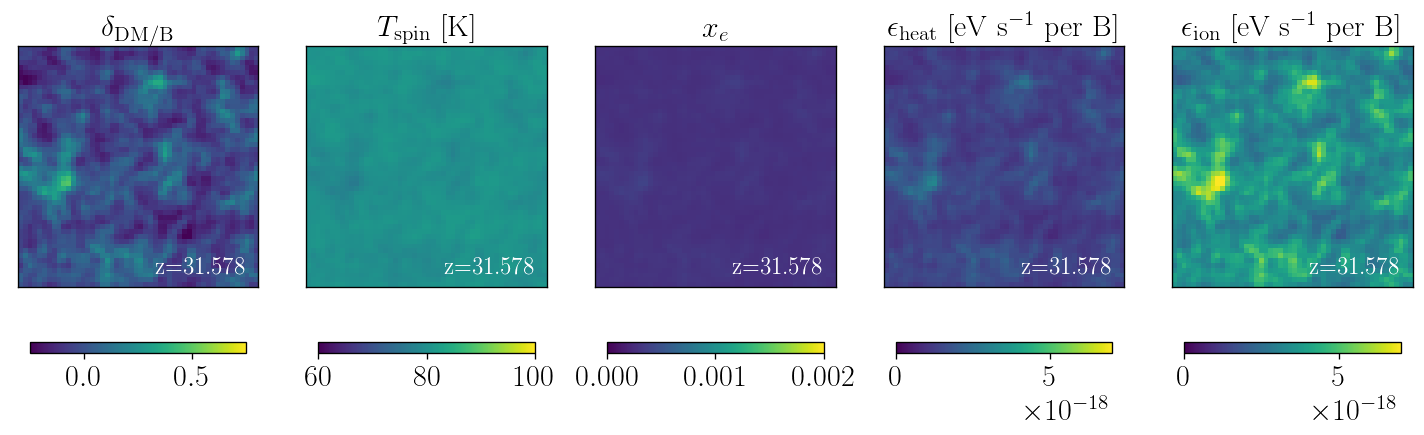

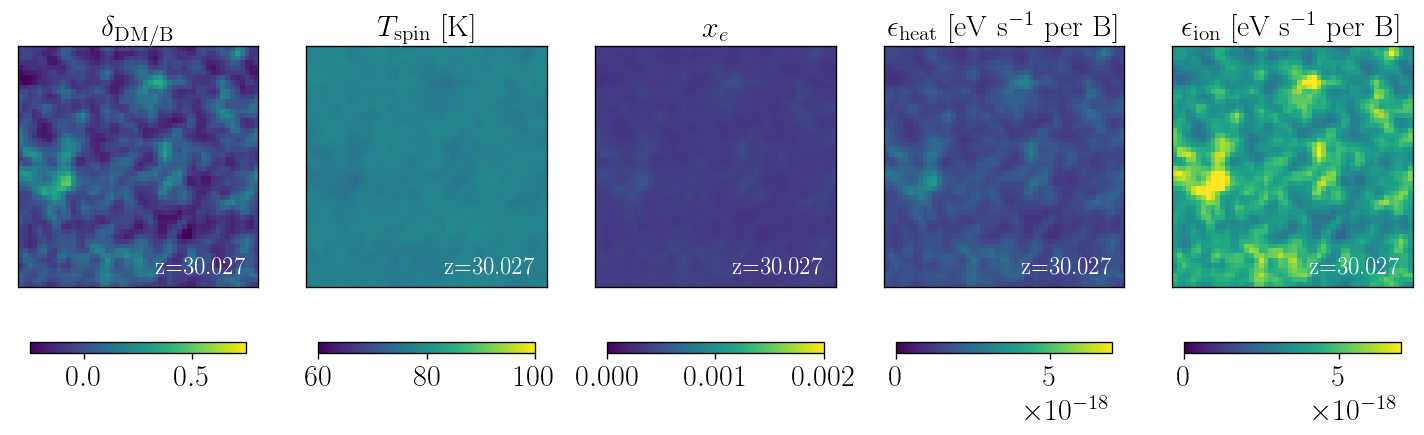

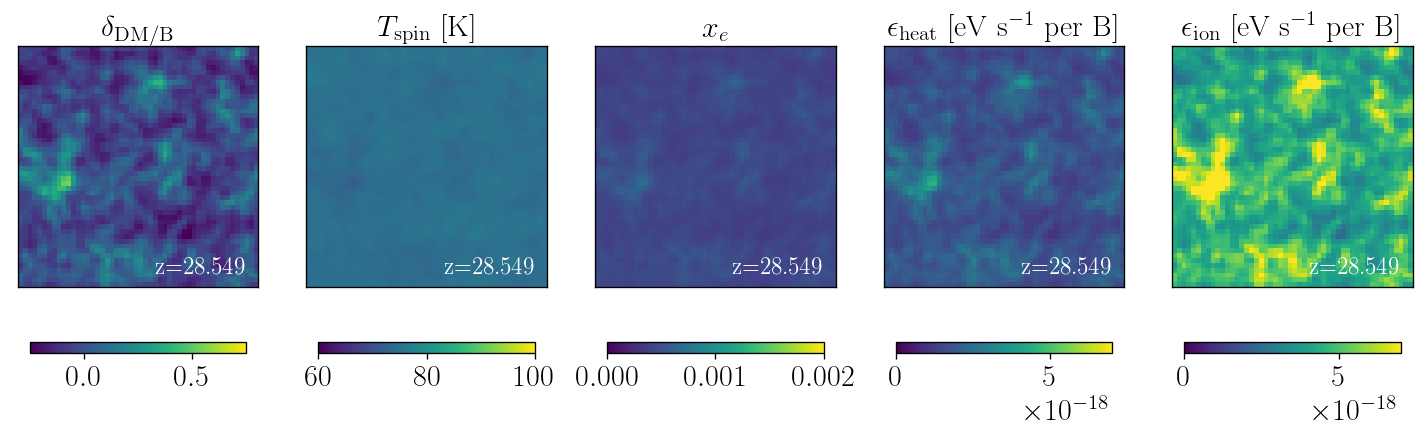

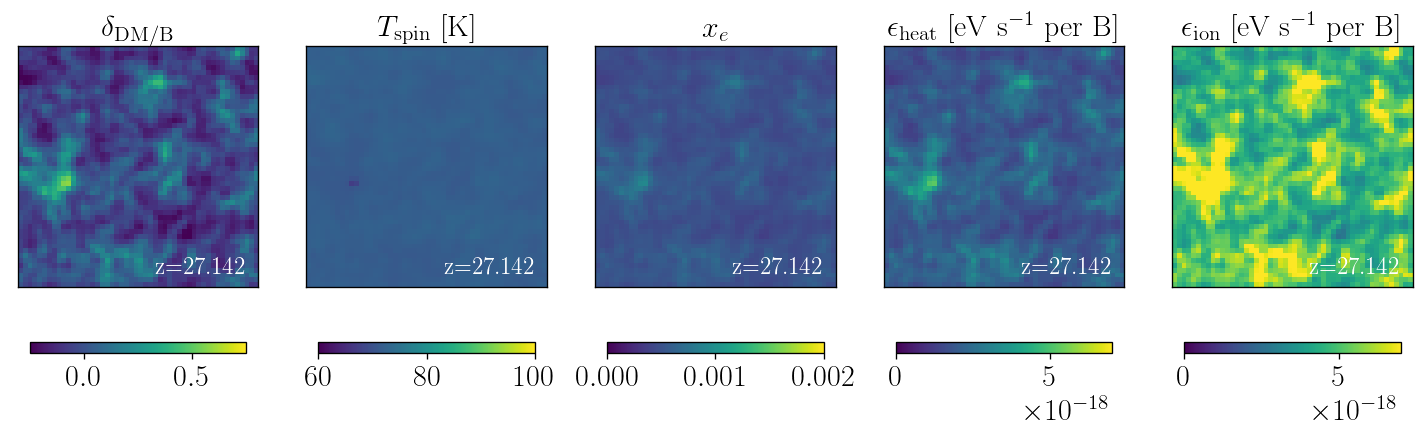

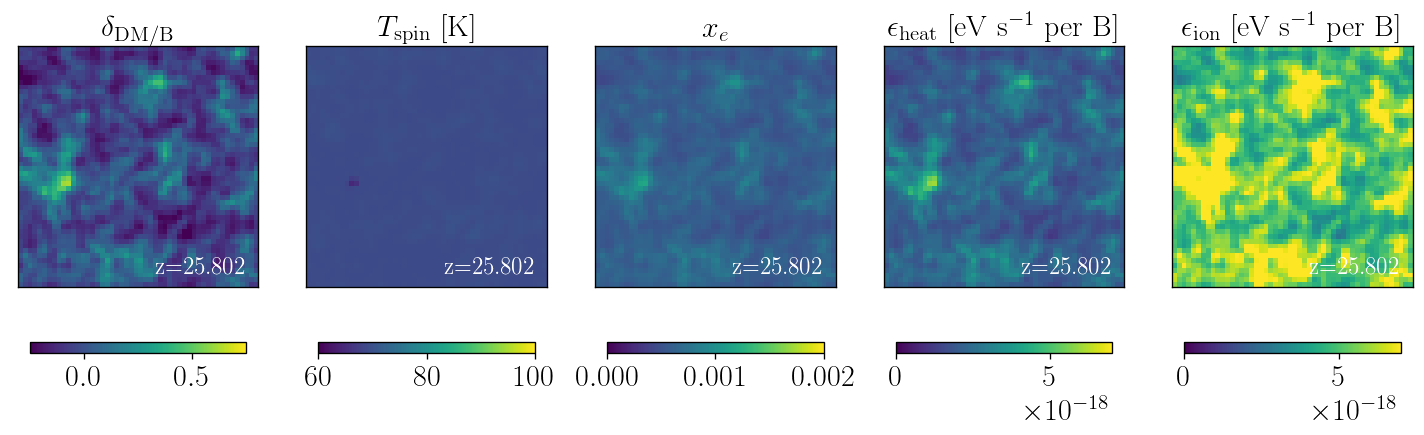

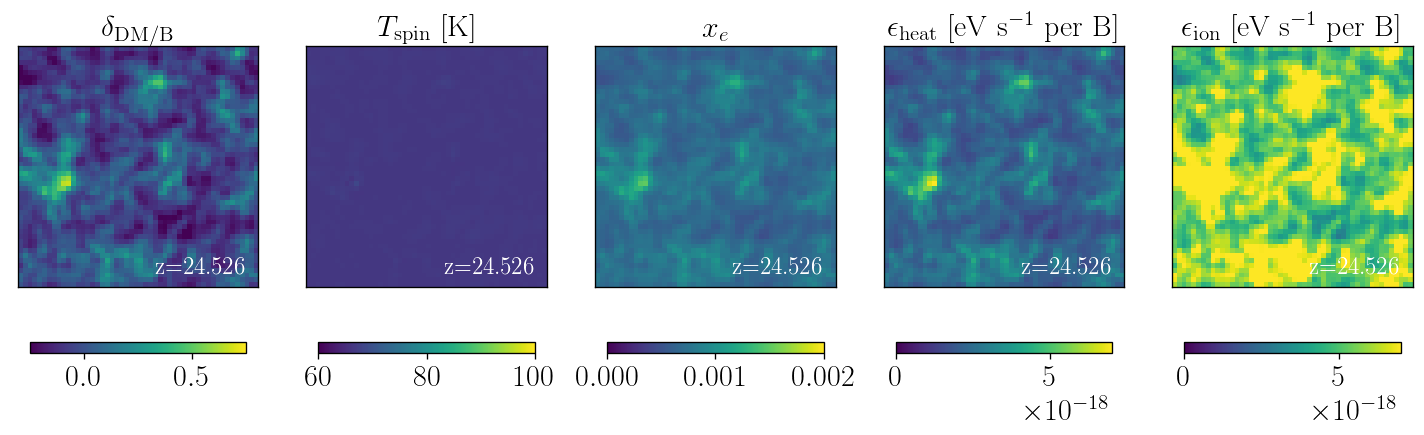

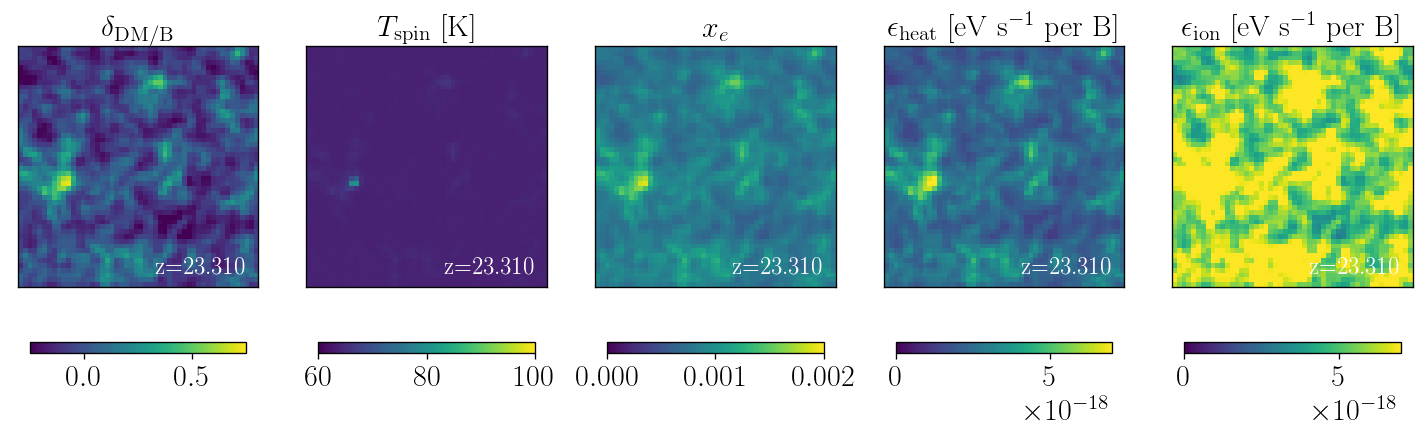

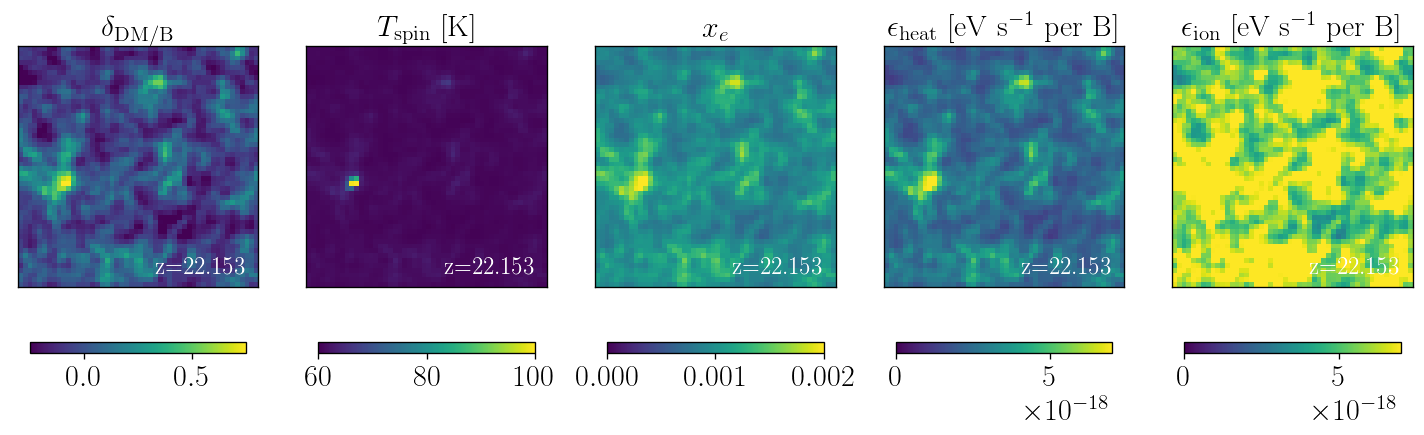

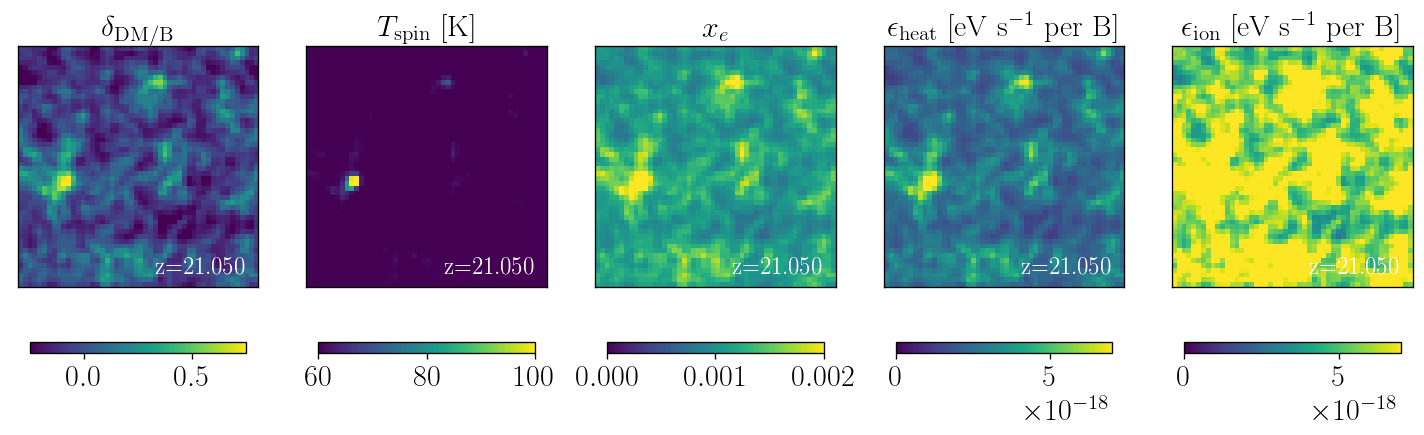

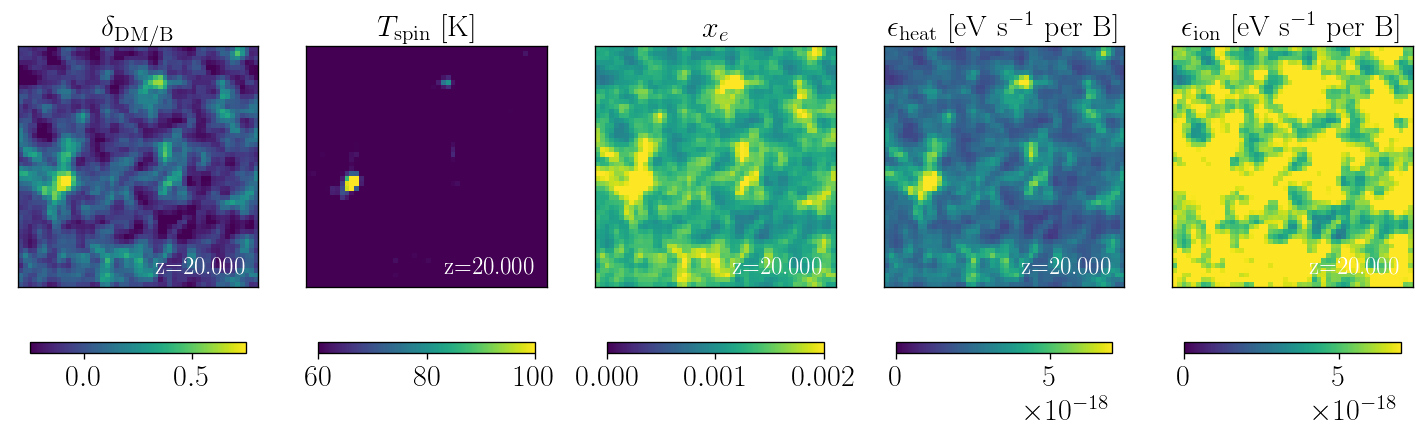

In [67]:
title={
    'delta' : r'$\delta_\mathrm{DM/B}$',
    'T_s'   : r'$T_\mathrm{spin}$ [K]',
    'x_e'   : r'$x_e$',
    'heat'  : r'$\epsilon_\mathrm{heat}$ [eV s$^{-1}$ per B]',
    'ion'   : r'$\epsilon_\mathrm{ion}$ [eV s$^{-1}$ per B]',
    'exc'   : r'$\epsilon_\mathrm{exc}$',
}
vrange={
    'delta' : (-0.25, 0.75),
    'T_s'   : (60., 100.),
    'x_e'   : (0., 0.002),
    'heat'  : (0., 7e-18),
    'ion'   : (0., 7e-18),
    'exc'   : (0., 1.),
}

for i_z, record in enumerate(tqdm(records)):

    fig, axs = plt.subplots(1, 5, figsize=(15, 4))
    for i, (k, x) in enumerate(record.items()):
        im = axs[i].imshow(x, vmin=vrange[k][0], vmax=vrange[k][1])
        axs[i].set(title=title[k], xticks=[], yticks=[])
        axs[i].text(28, 47, f'z={z_arr[i_z]:.3f}', color='w')
        fig.colorbar(im, ax=axs[i], orientation='horizontal', shrink=0.9)
    fig.savefig(f'plots/tmp/{i_z}.png')
    #plt.close()

In [68]:
import glob
import contextlib
from PIL import Image

# filepaths
fp_in = "plots/tmp/*.png"
fp_out = "plots/dh.gif"

# use exit stack to automatically close opened images
flist = glob.glob(fp_in)
with contextlib.ExitStack() as stack:
    imgs = (stack.enter_context(Image.open(f))
            for f in sorted(flist, key=lambda x: int(os.path.basename(x).split('.')[0])))
    # extract  first image from iterator
    durations = np.full(len(flist), 500)
    durations[-1] = 1500
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=list(durations), loop=0)

## 3. view result

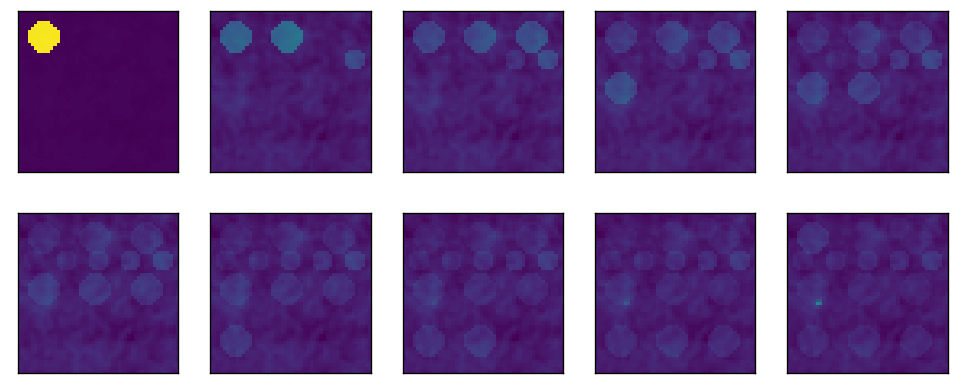

In [7]:
vmax = np.max(Tk_box_arr)

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(Tk_box_arr[i*5+j][25], vmax=vmax)
        axs[i,j].set(xticks=[], yticks=[])

In [8]:
ionized_box = p21c.ionize_box(
    spin_temp = spin_temp,
)

The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The followin

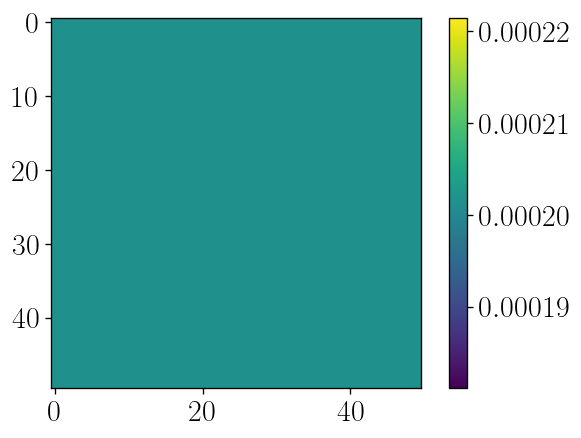

In [22]:
fig, ax = plt.subplots()
im = ax.imshow(1-ionized_box.xH_box[25])
fig.colorbar(im, ax=ax)

# Archive

## A. Some uniform calculation for scale

In [25]:
swave_process = dict(
    mode = 'swave',
    mDM = 2e6, # [eV]
    sigmav = 1e-26, # [cm^3 s^-1]
)
decay_process = dict(
    mode = 'decay',
    mDM = 4e6, # [eV]
    lifetime = 3e25, # [s]
)
process = swave_process

$$\mathcal{E}^{inj}=\frac{1}{n_B}\frac{dE}{dtdV}=(1+z)^3\frac{\Omega_{DM}^2}{\Omega_B}\rho_c(1+B(z))m_pc^2\frac{\langle\sigma v\rangle}{m_{DM}}$$

In [26]:
E_inj = phys.omega_DM**2 / phys.omega_baryon * phys.rho_crit * phys.m_p * process['sigmav'] / process['mDM']
print(f"E_inj = (1+z)^3 (1+B) * {E_inj:.4e} eV / s")

E_inj = (1+z)^3 (1+B) * 3.1821e-20 eV / s


$$\epsilon^{DM}_{heat}=f_{heat}\mathcal{E}^{inj}$$

In [27]:
z_high, z_low = 34.91712652, 33.20678716
delta_B = jnp.array([0.])
x_e = jnp.array([0.1])
f_boxs = get_DH_f_boxs(delta_B, x_e, z=z_high, **process)

eDMheat = (1+z_high)**3 * f_boxs['heat'].flatten()[0] * E_inj
print(f"e_DM_heat = (1+B) * {eDMheat:.4e} eV / s")

e_DM_heat = (1+B) * 1.1110e-19 eV / s


$$\Delta T=\frac{2}{3k_B(1+x_e)}\,\Delta t\,\epsilon^{DM}_{heat}$$

In [28]:
dT =  2 / (3*phys.kB) * phys.dt_between_z(z_high, z_low) * eDMheat / (1+x_e[0])
print(f"dT = (1+B) * {1000*dT:.4f} mK")

dT = (1+B) * 149.2254 mK


## B. Plotting

[Text(0.5, 1.0, 'input ionization'), [], []]

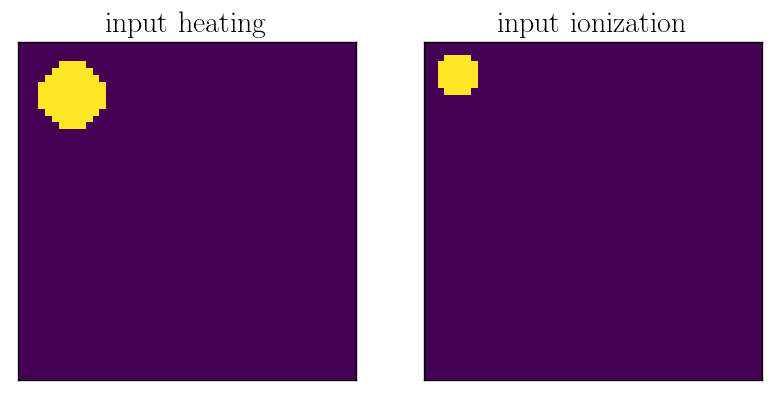

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
im0 = axs[0].imshow(input_heating.input_heating[25])
im1 = axs[1].imshow(input_ionization.input_ionization[25])

axs[0].set(title=r'input heating', xticks=[], yticks=[])
axs[1].set(title=r'input ionization', xticks=[], yticks=[])

#fig.colorbar(im0, ax=axs[0], orientation='horizontal')
#fig.colorbar(im1, ax=axs[1], orientation='horizontal')

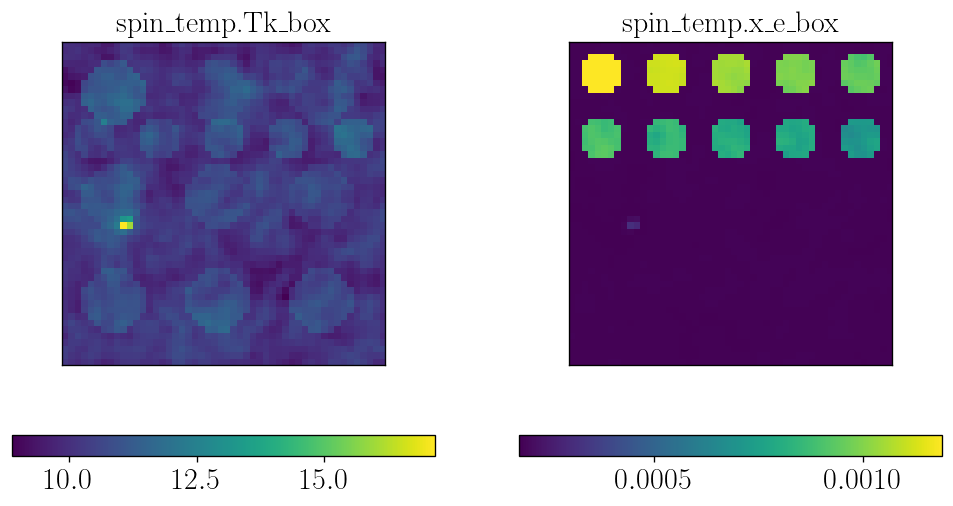

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
im0 = axs[0].imshow(spin_temp.Tk_box[25])
im1 = axs[1].imshow(spin_temp.x_e_box[25])

axs[0].set(title='spin_temp.Tk_box', xticks=[], yticks=[])
axs[1].set(title='spin_temp.x_e_box', xticks=[], yticks=[])

fig.colorbar(im0, ax=axs[0], orientation='horizontal')
fig.colorbar(im1, ax=axs[1], orientation='horizontal')